In [3]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(17621,)
(9710,) (7621,)


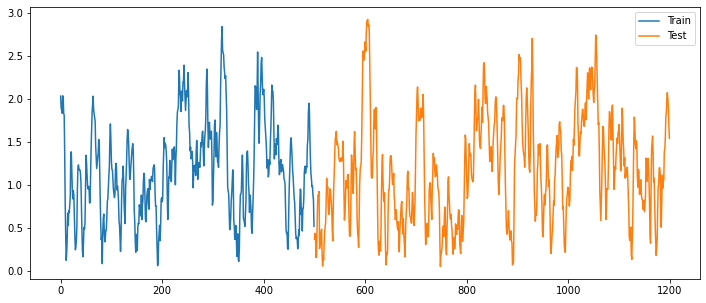

In [4]:
data = {}
entire_data = np.load('amplitude_data.npy')
print(entire_data.shape)
data['train'] = entire_data[:10000]
data['test'] = entire_data[10000:]
idx = np.where(data['train'] > 1e34)[0]
data['train'] = np.delete(data['train'], idx)
print(data['train'].shape, data['test'].shape)

N_train = 500
N_forecast = 700
Ztrain = data['train'][:N_train] 
Ztest = data['train'][N_train:N_train+N_forecast]
# data['train'] = np.load(f'{datadir}/amplitude_data.npy').T
# data['test'] = np.load(f'{datadir}/Z500_Test_Snapshots.npy').T

plt.figure(figsize=(12, 5))
plt.plot(np.arange(N_train), Ztrain)
plt.plot(np.arange(N_train, N_train+N_forecast), Ztest)
plt.legend(['Train', 'Test'])

In [11]:
def rolling(a, window):
    shape = (a.size - window + 1, window)
    strides = (a.itemsize, a.itemsize)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)



In [20]:
rolling_width = 3
Input_X = rolling(Ztrain[:-1], rolling_width)
print(Input_X.shape)
Output_Y = Ztrain[rolling_width:]
print(Output_Y.shape)
x_np = torch.from_numpy(Input_X)
y_np = torch.from_numpy(Output_Y)

(497, 3)
(497,)


In [49]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(x_np, y_np, likelihood)

In [50]:
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iter = 2 if smoke_test else 200


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    output = model(x_np)
    # Calc loss and backprop gradients
    loss = -mll(output, y_np)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item()
    ))
    optimizer.step()

Iter 1/200 - Loss: 0.829   lengthscale: 0.693   noise: 0.693
Iter 2/200 - Loss: 0.825   lengthscale: 0.698   noise: 0.688
Iter 3/200 - Loss: 0.821   lengthscale: 0.703   noise: 0.683
Iter 4/200 - Loss: 0.817   lengthscale: 0.708   noise: 0.678
Iter 5/200 - Loss: 0.813   lengthscale: 0.713   noise: 0.673
Iter 6/200 - Loss: 0.809   lengthscale: 0.718   noise: 0.669
Iter 7/200 - Loss: 0.805   lengthscale: 0.724   noise: 0.664
Iter 8/200 - Loss: 0.801   lengthscale: 0.729   noise: 0.659
Iter 9/200 - Loss: 0.797   lengthscale: 0.734   noise: 0.654
Iter 10/200 - Loss: 0.793   lengthscale: 0.739   noise: 0.649
Iter 11/200 - Loss: 0.789   lengthscale: 0.744   noise: 0.644
Iter 12/200 - Loss: 0.785   lengthscale: 0.749   noise: 0.640
Iter 13/200 - Loss: 0.781   lengthscale: 0.755   noise: 0.635
Iter 14/200 - Loss: 0.777   lengthscale: 0.760   noise: 0.630
Iter 15/200 - Loss: 0.773   lengthscale: 0.765   noise: 0.626
Iter 16/200 - Loss: 0.769   lengthscale: 0.770   noise: 0.621
Iter 17/200 - Los

Iter 137/200 - Loss: 0.278   lengthscale: 1.319   noise: 0.220
Iter 138/200 - Loss: 0.274   lengthscale: 1.323   noise: 0.218
Iter 139/200 - Loss: 0.270   lengthscale: 1.327   noise: 0.216
Iter 140/200 - Loss: 0.266   lengthscale: 1.331   noise: 0.214
Iter 141/200 - Loss: 0.262   lengthscale: 1.335   noise: 0.212
Iter 142/200 - Loss: 0.258   lengthscale: 1.338   noise: 0.210
Iter 143/200 - Loss: 0.254   lengthscale: 1.342   noise: 0.208
Iter 144/200 - Loss: 0.250   lengthscale: 1.346   noise: 0.206
Iter 145/200 - Loss: 0.246   lengthscale: 1.350   noise: 0.204
Iter 146/200 - Loss: 0.242   lengthscale: 1.353   noise: 0.202
Iter 147/200 - Loss: 0.238   lengthscale: 1.357   noise: 0.200
Iter 148/200 - Loss: 0.234   lengthscale: 1.361   noise: 0.198
Iter 149/200 - Loss: 0.230   lengthscale: 1.365   noise: 0.197
Iter 150/200 - Loss: 0.226   lengthscale: 1.368   noise: 0.195
Iter 151/200 - Loss: 0.222   lengthscale: 1.372   noise: 0.193
Iter 152/200 - Loss: 0.218   lengthscale: 1.376   noise

In [59]:
model.eval()
likelihood.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    temp = Ztest[:202]
    temp = rolling(temp, rolling_width)
    test_x = torch.from_numpy(temp)
    observed_pred = likelihood(model(test_x))

In [60]:
print(observed_pred)

MultivariateNormal(loc: torch.Size([200]))


(0.0, 4.0)

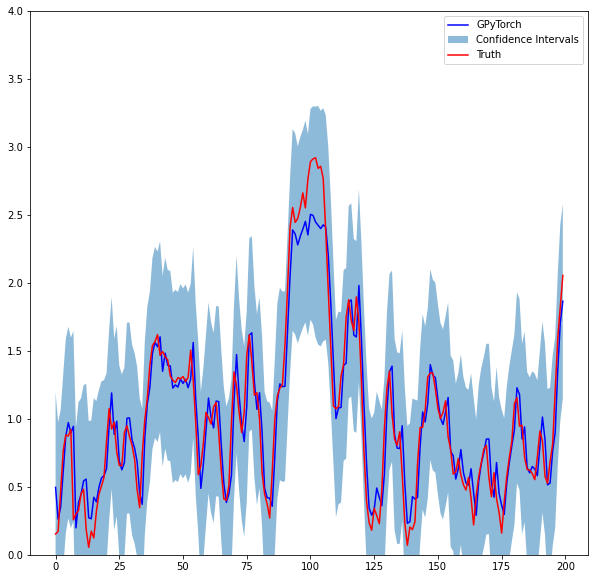

In [75]:
lower, upper = observed_pred.confidence_region()
f, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(np.arange(200), observed_pred.mean.numpy(), 'b')
ax.fill_between(np.arange(200), lower.detach().numpy(), upper.detach().numpy(), alpha=0.5)
ax.plot(np.arange(200),Ztest[3:3+200], 'r')
ax.legend(['GPyTorch','Confidence Intervals' ,'Truth'])
plt.ylim([0,4])

In [ ]:
# Training data is 100 points in [0,1] inclusive regularly spaced
train_x = torch.linspace(0, 1, 100)
# True function is sin(2*pi*x) with Gaussian noise
train_y = torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * math.sqrt(0.04)